In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size
n_kernels = 100 # Number of kernels in convolutional layer

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = np.ones((5,1)) - 0.02*h[i]
    xRight = np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-1, yLeft))
        RightImp = np.hstack((xRight-1, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((n_cases, 2, -1, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [27]:
y.shape

(144, 2)

In [28]:
x_para_train, x_para_test, x_train, x_test, y_train, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [29]:
x_train.shape

(129, 2, 55, 1)

In [30]:
y_train.shape

(129, 2)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=16, activation='relu', name='fc4')(x_fc3)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc4)
# CNN autoencoder
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 100)   500         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 100)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 2700)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
6/6 [==============================] - 4s 6ms/step - loss: 0.5837 - rmse: 0.7640 - lr: 0.0010
Epoch 2/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.1998 - rmse: 0.4470 - lr: 0.0010
Epoch 3/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.1275 - rmse: 0.3571 - lr: 0.0010
Epoch 4/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.1250 - rmse: 0.3535 - lr: 0.0010
Epoch 5/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0912 - rmse: 0.3020 - lr: 0.0010
Epoch 6/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.1207 - rmse: 0.3474 - lr: 0.0010
Epoch 7/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0982 - rmse: 0.3133 - lr: 0.0010
Epoch 8/5000
6/6 [==============================] - 0s 5ms/step - loss: 0.0924 - rmse: 0.3040 - lr: 0.0010
Epoch 9/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0815 - rmse: 0.2855 - lr: 0.0010
Epoch 10/5000
6/6 [==================

Epoch 77/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0122 - rmse: 0.1106 - lr: 0.0010
Epoch 78/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0130 - rmse: 0.1139 - lr: 0.0010
Epoch 79/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0123 - rmse: 0.1108 - lr: 0.0010
Epoch 80/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0112 - rmse: 0.1057 - lr: 0.0010
Epoch 81/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0100 - rmse: 0.1000 - lr: 0.0010
Epoch 82/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0141 - rmse: 0.1186 - lr: 0.0010
Epoch 83/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0126 - rmse: 0.1122 - lr: 0.0010
Epoch 84/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0153 - rmse: 0.1236 - lr: 0.0010
Epoch 85/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0130 - rmse: 0.1141 - lr: 0.0010
Epoch 86/5000
6/6 [=========

6/6 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0571 - lr: 0.0010
Epoch 153/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0100 - rmse: 0.1002 - lr: 0.0010
Epoch 154/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0102 - rmse: 0.1008 - lr: 0.0010
Epoch 155/5000
6/6 [==============================] - 0s 6ms/step - loss: 0.0077 - rmse: 0.0875 - lr: 0.0010
Epoch 156/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0040 - rmse: 0.0632 - lr: 0.0010
Epoch 157/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0060 - rmse: 0.0772 - lr: 0.0010
Epoch 158/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0041 - rmse: 0.0644 - lr: 0.0010
Epoch 159/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0488 - lr: 0.0010
Epoch 160/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0536 - lr: 0.0010
Epoch 161/5000
6/6 [==============

6/6 [==============================] - 0s 7ms/step - loss: 9.3946e-04 - rmse: 0.0307 - lr: 0.0010
Epoch 228/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0337 - lr: 0.0010
Epoch 229/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0445 - lr: 0.0010
Epoch 230/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0506 - lr: 0.0010
Epoch 231/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0426 - lr: 0.0010
Epoch 232/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0437 - lr: 0.0010
Epoch 233/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0485 - lr: 0.0010
Epoch 234/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0067 - rmse: 0.0820 - lr: 0.0010
Epoch 235/5000
6/6 [==============================] - 0s 7ms/step - loss: 0.0052 - rmse: 0.0719 - lr: 0.0010
Epoch 236/5000
6/6 [==========

6/6 [==============================] - 0s 7ms/step - loss: 2.3613e-04 - rmse: 0.0154 - lr: 0.0010
Epoch 301/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.2164e-04 - rmse: 0.0205 - lr: 0.0010
Epoch 302/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.8036e-04 - rmse: 0.0195 - lr: 0.0010
Epoch 303/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.9485e-04 - rmse: 0.0140 - lr: 0.0010
Epoch 304/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.1151e-04 - rmse: 0.0145 - lr: 0.0010
Epoch 305/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.5157e-04 - rmse: 0.0123 - lr: 0.0010
Epoch 306/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.0178e-04 - rmse: 0.0142 - lr: 0.0010
Epoch 307/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.9537e-04 - rmse: 0.0140 - lr: 0.0010
Epoch 308/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.7402e-04 - rmse: 0.0132 - lr: 0.001

6/6 [==============================] - 0s 7ms/step - loss: 4.2206e-04 - rmse: 0.0205 - lr: 0.0010
Epoch 374/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.2829e-04 - rmse: 0.0207 - lr: 0.0010
Epoch 375/5000
1/6 [====>.........................] - ETA: 0s - loss: 4.1311e-04 - rmse: 0.0203
Epoch 375: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 [==============================] - 0s 7ms/step - loss: 3.2579e-04 - rmse: 0.0180 - lr: 0.0010
Epoch 376/5000
6/6 [==============================] - 0s 8ms/step - loss: 1.3039e-04 - rmse: 0.0114 - lr: 5.0000e-04
Epoch 377/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.4182e-04 - rmse: 0.0119 - lr: 5.0000e-04
Epoch 378/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.8331e-04 - rmse: 0.0135 - lr: 5.0000e-04
Epoch 379/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.2214e-04 - rmse: 0.0149 - lr: 5.0000e-04
Epoch 380/5000
6/6 [=============================

Epoch 442/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.0739e-05 - rmse: 0.0090 - lr: 5.0000e-04
Epoch 443/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.1772e-05 - rmse: 0.0090 - lr: 5.0000e-04
Epoch 444/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.0466e-04 - rmse: 0.0102 - lr: 5.0000e-04
Epoch 445/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.5727e-05 - rmse: 0.0081 - lr: 5.0000e-04
Epoch 446/5000
6/6 [==============================] - 0s 7ms/step - loss: 9.4183e-05 - rmse: 0.0097 - lr: 5.0000e-04
Epoch 447/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.1874e-05 - rmse: 0.0085 - lr: 5.0000e-04
Epoch 448/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.0008e-04 - rmse: 0.0100 - lr: 5.0000e-04
Epoch 449/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.8661e-05 - rmse: 0.0094 - lr: 5.0000e-04
Epoch 450/5000
6/6 [==============================] - 0s 7ms/ste

6/6 [==============================] - 0s 7ms/step - loss: 6.0886e-05 - rmse: 0.0078 - lr: 5.0000e-04
Epoch 513/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.8997e-05 - rmse: 0.0070 - lr: 5.0000e-04
Epoch 514/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.5326e-05 - rmse: 0.0081 - lr: 5.0000e-04
Epoch 515/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.7446e-05 - rmse: 0.0076 - lr: 5.0000e-04
Epoch 516/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.8359e-05 - rmse: 0.0083 - lr: 5.0000e-04
Epoch 517/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.2173e-05 - rmse: 0.0072 - lr: 5.0000e-04
Epoch 518/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.0133e-05 - rmse: 0.0078 - lr: 5.0000e-04
Epoch 519/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.2177e-05 - rmse: 0.0079 - lr: 5.0000e-04
Epoch 520/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.021

6/6 [==============================] - 0s 7ms/step - loss: 5.4695e-05 - rmse: 0.0074 - lr: 5.0000e-04
Epoch 583/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.2355e-05 - rmse: 0.0072 - lr: 5.0000e-04
Epoch 584/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.2470e-05 - rmse: 0.0072 - lr: 5.0000e-04
Epoch 585/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.9035e-05 - rmse: 0.0070 - lr: 5.0000e-04
Epoch 586/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.9047e-05 - rmse: 0.0070 - lr: 5.0000e-04
Epoch 587/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.8762e-05 - rmse: 0.0083 - lr: 5.0000e-04
Epoch 588/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.0220e-05 - rmse: 0.0071 - lr: 5.0000e-04
Epoch 589/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.5044e-04 - rmse: 0.0123 - lr: 5.0000e-04
Epoch 590/5000
6/6 [==============================] - 0s 7ms/step - loss: 1.082

6/6 [==============================] - 0s 7ms/step - loss: 1.8505e-04 - rmse: 0.0136 - lr: 2.5000e-04
Epoch 651/5000
6/6 [==============================] - 0s 7ms/step - loss: 7.9213e-05 - rmse: 0.0089 - lr: 2.5000e-04
Epoch 652/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.0669e-05 - rmse: 0.0090 - lr: 2.5000e-04
Epoch 653/5000
6/6 [==============================] - 0s 7ms/step - loss: 8.2917e-05 - rmse: 0.0091 - lr: 2.5000e-04
Epoch 654/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.6917e-05 - rmse: 0.0075 - lr: 2.5000e-04
Epoch 655/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.0717e-05 - rmse: 0.0078 - lr: 2.5000e-04
Epoch 656/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.8657e-05 - rmse: 0.0070 - lr: 2.5000e-04
Epoch 657/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.1611e-05 - rmse: 0.0072 - lr: 2.5000e-04
Epoch 658/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.687

6/6 [==============================] - 0s 7ms/step - loss: 3.0571e-05 - rmse: 0.0055 - lr: 2.5000e-04
Epoch 721/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.2725e-05 - rmse: 0.0057 - lr: 2.5000e-04
Epoch 722/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.7399e-05 - rmse: 0.0061 - lr: 2.5000e-04
Epoch 723/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.9706e-05 - rmse: 0.0063 - lr: 2.5000e-04
Epoch 724/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.1367e-05 - rmse: 0.0064 - lr: 2.5000e-04
Epoch 725/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.8617e-05 - rmse: 0.0062 - lr: 2.5000e-04
Epoch 726/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.2256e-05 - rmse: 0.0057 - lr: 2.5000e-04
Epoch 727/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.9743e-05 - rmse: 0.0063 - lr: 2.5000e-04
Epoch 728/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.083

6/6 [==============================] - 0s 7ms/step - loss: 4.2374e-05 - rmse: 0.0065 - lr: 1.2500e-04
Epoch 789/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.6888e-05 - rmse: 0.0068 - lr: 1.2500e-04
Epoch 790/5000
6/6 [==============================] - 0s 7ms/step - loss: 6.6246e-05 - rmse: 0.0081 - lr: 1.2500e-04
Epoch 791/5000
6/6 [==============================] - 0s 7ms/step - loss: 5.6483e-05 - rmse: 0.0075 - lr: 1.2500e-04
Epoch 792/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.4136e-05 - rmse: 0.0066 - lr: 1.2500e-04
Epoch 793/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.7858e-05 - rmse: 0.0062 - lr: 1.2500e-04
Epoch 794/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.0183e-05 - rmse: 0.0055 - lr: 1.2500e-04
Epoch 795/5000
6/6 [==============================] - 0s 8ms/step - loss: 2.5233e-05 - rmse: 0.0050 - lr: 1.2500e-04
Epoch 796/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.352

6/6 [==============================] - 0s 7ms/step - loss: 2.9127e-05 - rmse: 0.0054 - lr: 1.2500e-04
Epoch 859/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.5709e-05 - rmse: 0.0051 - lr: 1.2500e-04
Epoch 860/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.9738e-05 - rmse: 0.0055 - lr: 1.2500e-04
Epoch 861/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.4692e-05 - rmse: 0.0059 - lr: 1.2500e-04
Epoch 862/5000
6/6 [==============================] - 0s 7ms/step - loss: 4.0920e-05 - rmse: 0.0064 - lr: 1.2500e-04
Epoch 863/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.8259e-05 - rmse: 0.0062 - lr: 1.2500e-04
Epoch 864/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.4676e-05 - rmse: 0.0059 - lr: 1.2500e-04
Epoch 865/5000
1/6 [====>.........................] - ETA: 0s - loss: 4.9406e-05 - rmse: 0.0070
Epoch 865: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
6/6 [==================

6/6 [==============================] - 0s 7ms/step - loss: 3.2869e-05 - rmse: 0.0057 - lr: 6.2500e-05
Epoch 927/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.3961e-05 - rmse: 0.0049 - lr: 6.2500e-05
Epoch 928/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.6915e-05 - rmse: 0.0052 - lr: 6.2500e-05
Epoch 929/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.6063e-05 - rmse: 0.0051 - lr: 6.2500e-05
Epoch 930/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.8041e-05 - rmse: 0.0053 - lr: 6.2500e-05
Epoch 931/5000
6/6 [==============================] - 0s 7ms/step - loss: 3.1355e-05 - rmse: 0.0056 - lr: 6.2500e-05
Epoch 932/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.8502e-05 - rmse: 0.0053 - lr: 6.2500e-05
Epoch 933/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.9610e-05 - rmse: 0.0054 - lr: 6.2500e-05
Epoch 934/5000
6/6 [==============================] - 0s 7ms/step - loss: 2.719

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:00:46.858008


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"AeroCNN_I"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

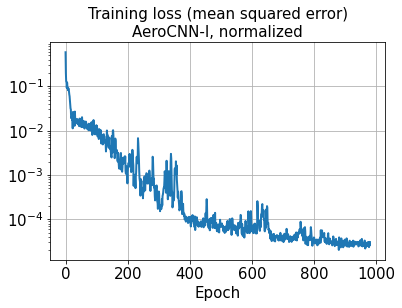

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-I, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

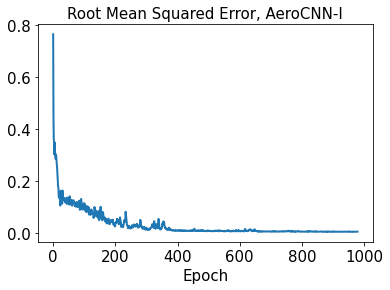

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-I', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

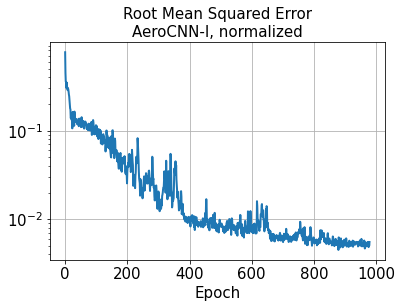

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nAeroCNN-I, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 174ms/step - loss: 1.6070e-04 - rmse: 0.0127


In [44]:
decoded_train = model.predict([x_train, x_para_train])
decoded_test = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 16ms/step


In [45]:
model_directory = "D:\\TrainedModels\\20221112"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221112steadyValidation_AeroCNN-I_test"+str(test_rate)+ "_" + str(n_units) +"units.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = np.abs(decoded_train - y_train)

In [47]:
error_test_abs = np.abs(decoded_test - y_test)

In [48]:
os.chdir(storage_dir)

In [49]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.006286525218554608


In [50]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.014651252989204094


In [51]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[0] - y_train[0])**2) / np.sum(y_train[0]**2))
print(l2_error_Cd_train)

0.0006364968291834833


In [52]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[1] - y_train[1])**2) / np.sum(y_train[1]**2))
print(l2_error_Cl_train)

0.003098245229004099


In [53]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[0] - y_test[0])**2) / np.sum(y_test[0]**2))
print(l2_error_Cd_test)

0.02247377540315267


In [54]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[1] - y_test[1])**2) / np.sum(y_test[1]**2))
print(l2_error_Cl_test)

0.014117708514347287


In [55]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [57]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [58]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [59]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [60]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

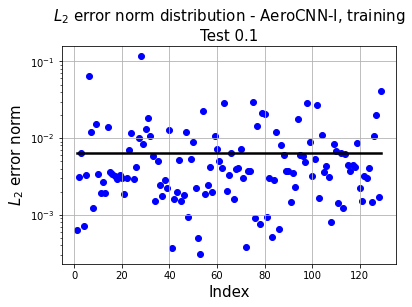

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nTest {}'.format(test_rate), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

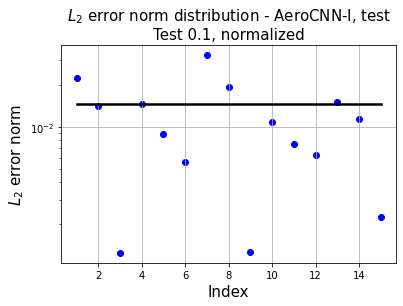

In [62]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nTest {}, normalized'.format(test_rate), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

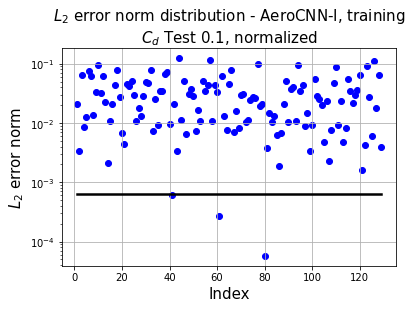

In [63]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_d$ Test {}, normalized'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

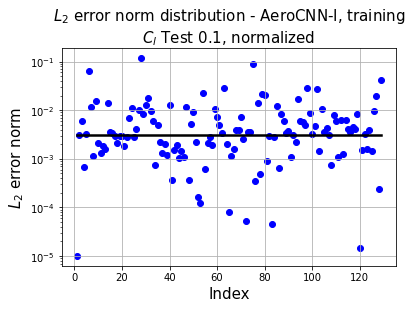

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\n$C_l$ Test {}, normalized'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

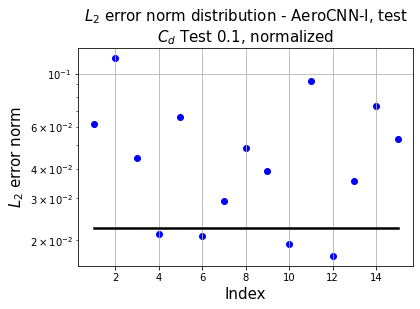

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_d$ Test {}, normalized'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

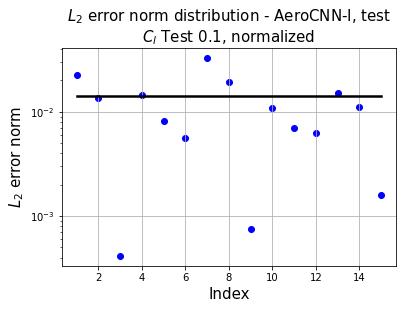

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\n$C_l$ Test {}, normalized'.format(test_rate), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()